In [1]:
!pip install statsforecast

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import OneHotEncoder
from pylab import rcParams
import os
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 


StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 3, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 26.5 MB/s eta 0:00:00


In [2]:
# Load dataset
konya = pd.read_parquet("abfss://Projeto_ii_ML_models@onelake.dfs.fabric.microsoft.com/Konya_sales.Lakehouse/Files/konya_features.parquet")

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 4, Finished, Available, Finished)

In [3]:
# vizualize dataset
konya.head()
konya.tail()

# print info
print(konya.info())

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 5, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532614 entries, 0 to 532613
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   store_id               532614 non-null  object        
 1   product_id             532614 non-null  object        
 2   date                   532614 non-null  datetime64[ns]
 3   sales                  532614 non-null  float64       
 4   revenue                532614 non-null  float64       
 5   stock                  532614 non-null  float64       
 6   price                  531602 non-null  float64       
 7   promo_type_1           532614 non-null  category      
 8   promo_bin_1            75780 non-null   category      
 9   promo_type_2           532614 non-null  category      
 10  promo_bin_2            479 non-null     category      
 11  promo_discount_2       479 non-null     float64       
 12  promo_discount_type_2  479 non-null     cate

In [4]:
# change dtypes 

cat_col = ['store_id', 'product_id', 'season', 'week']
konya[cat_col] = konya[cat_col].astype('category')

# Drop columns not necessary
df = konya.copy()
# List of columns to drop
columns_to_drop = [
    'promo_bin_1', 
    'promo_bin_2',
    'revenue', 
    'promo_discount_2', 
    'promo_discount_type_2', 
    'hierarchy2_id', 
    'hierarchy3_id', 
    'hierarchy4_id', 
    'hierarchy5_id', 
    'city_id_old', 
    'country_id', 
    'city_code',
    'product_length', 
    'product_depth',
    'product_width',
    'weekday'
]

# Drop the specified columns
df = df.drop(columns=columns_to_drop, errors='ignore')

#confirm drop
df.info()

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 6, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532614 entries, 0 to 532613
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   store_id       532614 non-null  category      
 1   product_id     532614 non-null  category      
 2   date           532614 non-null  datetime64[ns]
 3   sales          532614 non-null  float64       
 4   stock          532614 non-null  float64       
 5   price          531602 non-null  float64       
 6   promo_type_1   532614 non-null  category      
 7   promo_type_2   532614 non-null  category      
 8   cluster_id     532614 non-null  category      
 9   hierarchy1_id  532614 non-null  category      
 10  storetype_id   532614 non-null  category      
 11  store_size     532614 non-null  int64         
 12  season         532614 non-null  category      
 13  week           532614 non-null  category      
 14  holiday        532614 non-null  category      
 15  

In [5]:
# Get unique store_ids
unique_store_ids = df['store_id'].unique()

# Create a dictionary of DataFrames, each keyed by store_id
store_datasets = {}
for store_id in unique_store_ids:
    store_datasets[store_id] = df[df['store_id'] == store_id].copy()

# dataset for store_id 'S0142'
store_S0142	 = store_datasets['S0142']
print("Store S0142 dataset:")
print(store_S0142.head())

# dataset for store_id S0094
store_S0094	 = store_datasets['S0094']
print("Store S0094 dataset:")
print(store_S0094.head())

# dataset for store_id S0030
store_S0030	 = store_datasets['S0030']
print("Store S0030 dataset:")
print(store_S0030.head())


StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 7, Finished, Available, Finished)

Store S0142 dataset:
       store_id product_id       date  sales  stock  price promo_type_1  \
329161    S0142      P0001 2017-01-02    0.0    1.0   6.25         PR14   
329162    S0142      P0005 2017-01-02    0.0    2.0  33.90         PR14   
329163    S0142      P0015 2017-01-02    0.0   12.0   2.60         PR14   
329164    S0142      P0017 2017-01-02    0.0   17.0   1.49         PR14   
329165    S0142      P0018 2017-01-02    0.0    2.0   1.95         PR14   

       promo_type_2 cluster_id hierarchy1_id storetype_id  store_size season  \
329161         PR03  cluster_5           H01         ST04          31      1   
329162         PR03  cluster_9           H03         ST04          31      1   
329163         PR03  cluster_1           H00         ST04          31      1   
329164         PR03  cluster_6           H00         ST04          31      1   
329165         PR03  cluster_4           H00         ST04          31      1   

       week holiday month_name  
329161    1   

In [6]:
# select store as df
df1 = store_S0094.copy() # replace according to store
df1

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 8, Finished, Available, Finished)

,store_id,product_id,date,sales,stock,price,promo_type_1,promo_type_2,cluster_id,hierarchy1_id,storetype_id,store_size,season,week,holiday,month_name
62046,S0094,P0001,2017-01-02,0.0,6.0,6.25,PR14,PR03,cluster_5,H01,ST04,45,1,1,N,Jan
62047,S0094,P0011,2017-01-02,0.0,3.0,49.90,PR14,PR03,cluster_0,H03,ST04,45,1,1,N,Jan
62048,S0094,P0015,2017-01-02,0.0,6.0,2.60,PR14,PR03,cluster_1,H00,ST04,45,1,1,N,Jan
62049,S0094,P0017,2017-01-02,0.0,91.0,1.49,PR14,PR03,cluster_6,H00,ST04,45,1,1,N,Jan
62050,S0094,P0018,2017-01-02,0.0,17.0,1.95,PR14,PR03,cluster_4,H00,ST04,45,1,1,N,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329156,S0094,P0738,2019-09-30,0.0,9.0,9.95,PR14,PR03,cluster_0,H01,ST04,45,3,40,N,Sep
329157,S0094,P0739,2019-09-30,2.0,14.0,5.00,PR14,PR03,cluster_3,H03,ST04,45,3,40,N,Sep
329158,S0094,P0741,2019-09-30,0.0,14.0,32.90,PR10,PR03,cluster_0,H01,ST04,45,3,40,N,Sep
329159,S0094,P0742,2019-09-30,0.0,4.0,69.90,PR07,PR03,cluster_0,H01,ST04,45,3,40,N,Sep


In [7]:
df1.to_csv('abfss://Projeto_ii_ML_models@onelake.dfs.fabric.microsoft.com/Konya_sales.Lakehouse/Files/S0094.csv')

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 9, Finished, Available, Finished)

In [8]:
# get number of product_ids from store

store_S0094['product_id'].nunique()

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 10, Finished, Available, Finished)

470

## S0094

In [9]:
# Change the granularity of time series data from daily to weekly

# Set 'ds' column as the index
df1.set_index('date', inplace=True)
# Sort the DataFrame by the index (dates)
df1.sort_index(inplace=True)

# Group by 'product_id' and resample to weekly frequency
df_weekly = df1.groupby(['product_id']).resample('W-MON').agg({
    'sales': 'sum',  # Aggregate sales data
    'stock': 'last',  # Take the last stock value of the week
    'price': 'last',  # Last price for the week
    'promo_type_1': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'promo_type_2': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'cluster_id': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'hierarchy1_id': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'storetype_id': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'store_size': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'season': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'holiday': lambda x: x.mode().iloc[0] if not x.mode().empty else None, 
    'week': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'month_name': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
}).reset_index()

# Display the weekly aggregated DataFrame
print(df_weekly.head())

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 11, Finished, Available, Finished)

  product_id       date  sales  stock  price promo_type_1 promo_type_2  \
0      P0001 2017-01-02    0.0    6.0   6.25         PR14         PR03   
1      P0001 2017-01-09    0.0    6.0   6.25         PR14         PR03   
2      P0001 2017-01-16    2.0    4.0   6.50         PR14         PR03   
3      P0001 2017-01-23    3.0    1.0   6.50         PR14         PR03   
4      P0001 2017-01-30    0.0    1.0   6.50         PR14         PR03   

  cluster_id hierarchy1_id storetype_id  store_size  season holiday  week  \
0  cluster_5           H01         ST04        45.0     1.0       N   1.0   
1  cluster_5           H01         ST04        45.0     1.0       N   2.0   
2  cluster_5           H01         ST04        45.0     1.0       N   3.0   
3  cluster_5           H01         ST04        45.0     1.0       N   4.0   
4  cluster_5           H01         ST04        45.0     1.0       N   5.0   

  month_name  
0        Jan  
1        Jan  
2        Jan  
3        Jan  
4        Jan  


In [10]:
df_weekly.info()
#df.info()

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 12, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42236 entries, 0 to 42235
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   product_id     42236 non-null  category      
 1   date           42236 non-null  datetime64[ns]
 2   sales          42236 non-null  float64       
 3   stock          39089 non-null  float64       
 4   price          39004 non-null  float64       
 5   promo_type_1   39089 non-null  object        
 6   promo_type_2   39089 non-null  object        
 7   cluster_id     39089 non-null  object        
 8   hierarchy1_id  39089 non-null  object        
 9   storetype_id   39089 non-null  object        
 10  store_size     39089 non-null  float64       
 11  season         39089 non-null  float64       
 12  holiday        39089 non-null  object        
 13  week           39089 non-null  float64       
 14  month_name     39089 non-null  object        
dtypes: category(1), dat

In [11]:
# Sort DataFrame by 'date'
df_weekly = df_weekly.sort_values(by='date')
#df = df.sort_values(by='date')

# Reset index after sorting
df_weekly.reset_index(drop=True, inplace=True)
#df.reset_index(drop=True, inplace=True)

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 13, Finished, Available, Finished)

In [12]:
# Filter products that are present in 2019
products_in_2019 = df_weekly[df_weekly['date'].dt.year == 2019]['product_id'].unique()

# Filter the original DataFrame to include only products sold in 2019
df_filtered = df_weekly.loc[df_weekly['product_id'].isin(products_in_2019)]


# Display the last few rows of the filtered DataFrame
df_filtered.head()

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 14, Finished, Available, Finished)

,product_id,date,sales,stock,price,promo_type_1,promo_type_2,cluster_id,hierarchy1_id,storetype_id,store_size,season,holiday,week,month_name
1,P0151,2017-01-02,0.0,3.0,5.90,PR14,PR03,cluster_0,H01,ST04,45.0,1.0,N,1.0,Jan
2,P0333,2017-01-02,0.0,1.0,1.85,PR14,PR03,cluster_4,H00,ST04,45.0,1.0,N,1.0,Jan
3,P0454,2017-01-02,0.0,11.0,2.10,PR14,PR03,cluster_4,H00,ST04,45.0,1.0,N,1.0,Jan
4,P0071,2017-01-02,0.0,7.0,9.45,PR14,PR03,cluster_0,H01,ST04,45.0,1.0,N,1.0,Jan
5,P0226,2017-01-02,0.0,4.0,1.50,PR14,PR03,cluster_0,H01,ST04,45.0,1.0,N,1.0,Jan


In [13]:
df_filtered.tail()
#df.tail()

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 15, Finished, Available, Finished)

,product_id,date,sales,stock,price,promo_type_1,promo_type_2,cluster_id,hierarchy1_id,storetype_id,store_size,season,holiday,week,month_name
42231,P0498,2019-09-30,0.0,3.0,299.90,PR14,PR03,cluster_0,H03,ST04,45.0,3.0,N,39.0,Sep
42232,P0499,2019-09-30,20.0,21.0,0.75,PR14,PR03,cluster_0,H00,ST04,45.0,3.0,N,39.0,Sep
42233,P0090,2019-09-30,0.0,35.0,4.90,PR14,PR03,cluster_0,H03,ST04,45.0,3.0,N,39.0,Sep
42234,P0481,2019-09-30,0.0,3.0,8.90,PR14,PR03,cluster_9,H03,ST04,45.0,3.0,N,39.0,Sep
42235,P0748,2019-09-30,0.0,16.0,18.90,PR14,PR03,cluster_0,H01,ST04,45.0,3.0,N,39.0,Sep


# **ARIMA**

### All time range included

In [14]:
# Adjust column names if needed
df_filtered = df_filtered.rename(columns={
    'product_id': 'unique_id',
    'date': 'ds',
    'sales': 'y'
})


# Rename variable
data = df_filtered.copy()

# Ensure 'unique_id' and 'ds' are properly formatted
data['unique_id'] = data['unique_id'].astype(str)
data['ds'] = pd.to_datetime(data['ds'])

# Separate sales and date from exogenous variables
data2 = data[['ds', 'unique_id', 'y']]


# Define AutoArima model
model = [AutoARIMA(season_length=52)]
#Forecast
sf = StatsForecast(models=model, freq='W-MON', n_jobs=-1)

# Define horizon and level for AutoARIMA
horizon = 2
level = [90]

# Forecast
fcst = sf.forecast(df=data2, h=horizon, level=level)
fcst.head()


StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 16, Finished, Available, Finished)

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
P0005,2019-10-07,0.097343,-0.438197,0.632883
P0005,2019-10-14,0.044856,-0.491544,0.581255
P0006,2019-07-01,0.084876,-0.850439,1.020190
P0006,2019-07-08,-0.051847,-1.011521,0.907828
P0007,2019-09-30,0.427889,-0.098645,0.954424


In [15]:
# Convert 'ds' to datetime
fcst['ds'] = pd.to_datetime(fcst['ds'])

# Find the maximum date in the dataset
max_date = fcst['ds'].max()

# Calculate the date two weeks before the maximum date
two_weeks_ago = max_date - pd.Timedelta(weeks=2)

# Filter the DataFrame to keep only the rows within the last two weeks
filtered_df2 = fcst[fcst['ds'] > two_weeks_ago]

filtered_df2

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 17, Finished, Available, Finished)

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
P0005,2019-10-07,0.097343,-0.438197,0.632883
P0005,2019-10-14,0.044856,-0.491544,0.581255
P0007,2019-10-07,0.228821,-0.490328,0.947970
P0008,2019-10-07,0.882989,-1.248524,3.014502
P0008,2019-10-14,0.882638,-1.249249,3.014524
...,...,...,...,...
P0741,2019-10-14,0.000000,-0.764841,0.764841
P0742,2019-10-07,-0.000002,-0.994910,0.994907
P0742,2019-10-14,0.000000,-1.106395,1.106395


In [ ]:
# save to csv
filtered_df2.to_csv('abfss://Projeto_ii_ML_models@onelake.dfs.fabric.microsoft.com/Konya_sales.Lakehouse/Files/FORECAST_S0094.csv') 

StatementMeta(, , , Cancelled, , Cancelled)

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 18, Finished, Available, Finished)

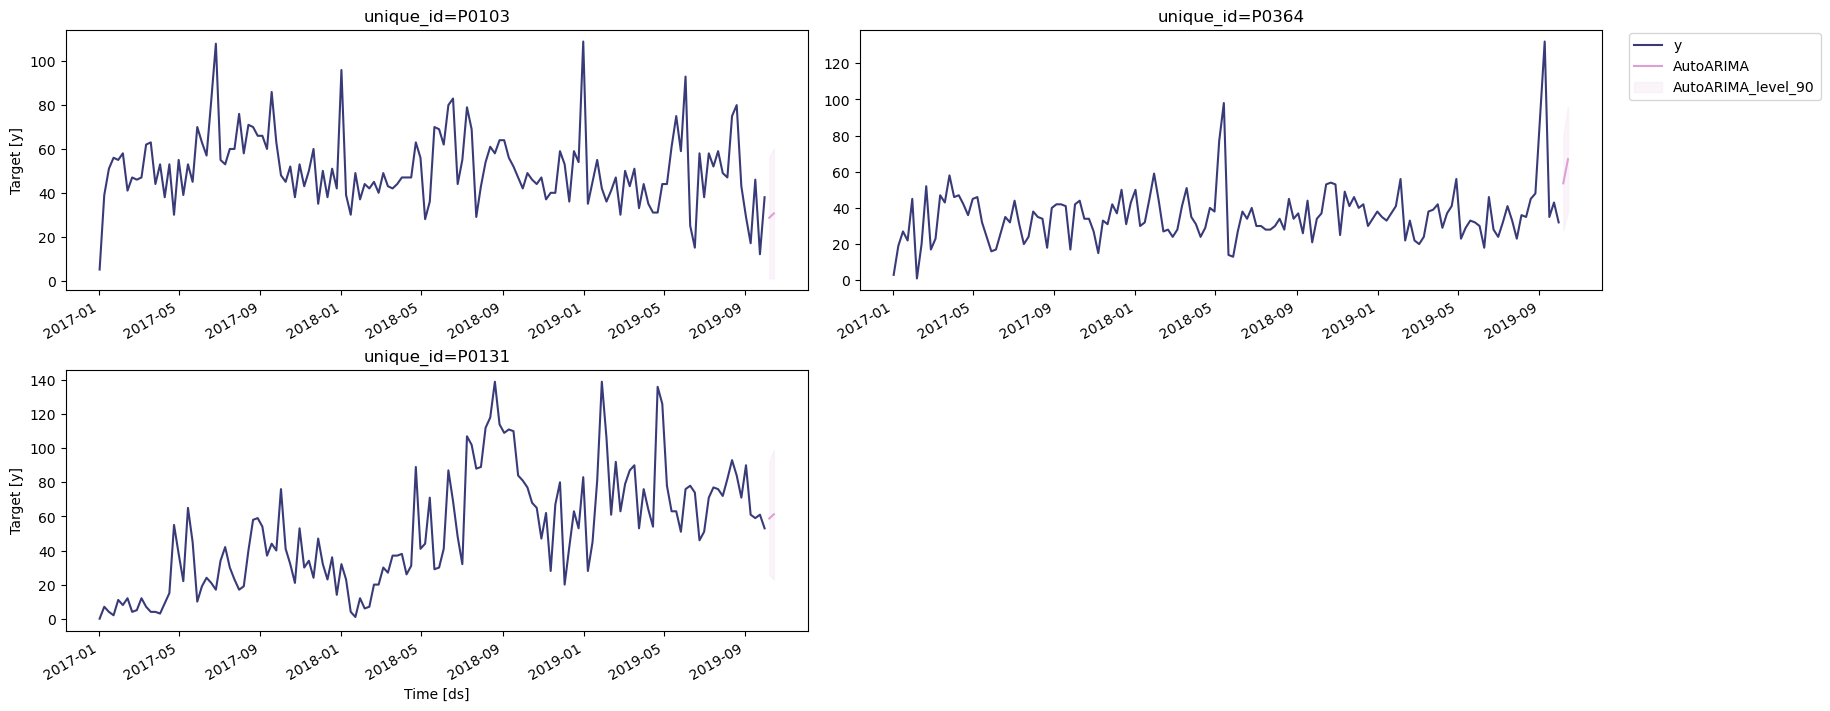

In [16]:
sf.plot(data2, fcst, models=["AutoARIMA"], unique_ids=['P0103', 'P0364', 'P0131'], level=[90])


In [18]:
unique_ids = ['P0103', 'P0364', 'P0131']
filtered_df3 = fcst[fcst['ds'] >= max_date ]

filtered_df3 = filtered_df3.loc[unique_ids]
filtered_df3

StatementMeta(, 43c27616-bd62-40ca-9831-a93edae1d5b0, 20, Finished, Available, Finished)

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
P0103,2019-10-14,30.622007,0.939955,60.304058
P0364,2019-10-14,66.936806,37.789753,96.083855
P0131,2019-10-14,61.259556,23.075565,99.443550
